In [52]:
import numpy as np
import optuna
import optunahub
import pandas as pd
from IPython.core.pylabtools import figsize
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, \
    median_absolute_error

In [32]:
df = pd.read_parquet('../data/data_with_meteo.parquet')
sf = df.dropna(inplace=True)

In [33]:
df['duedate'] = pd.to_datetime(df['duedate'])
df['hour'] = df['duedate'].dt.hour
df['dayofweek'] = df['duedate'].dt.dayofweek  # 0=lundi
df['is_weekend'] = df['dayofweek'] >= 5


In [34]:
y_columns = ['numdocksavailable', 'numbikesavailable']
X_columns = df.columns.difference(y_columns + ['coordonnees_geo', 'duedate'])
X = df[X_columns]
y = df['numdocksavailable']

split_date = "2025-12-20"

# Features
X_train = df.loc[df["duedate"] < split_date, X_columns]
X_test  = df.loc[df["duedate"] >= split_date, X_columns]

# Target
y_train = df.loc[df["duedate"] < split_date, y_columns]
y_test  = df.loc[df["duedate"] >= split_date, y_columns]

In [35]:
s = (X_train.dtypes == 'object')
cat_cols = list(s[s].index)
cat_cols

['code_insee_commune',
 'is_installed',
 'is_renting',
 'is_returning',
 'name',
 'nom_arrondissement_communes',
 'stationcode']

In [43]:
def objective(trial):

    params = {
        "loss_function": "MultiRMSE",
        "iterations": trial.suggest_int("iterations", 50, 1000, log=True),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 50.0, log=True),

        # Catégorielles
        "one_hot_max_size": trial.suggest_int("one_hot_max_size", 2, 20),
        "max_ctr_complexity": trial.suggest_int("max_ctr_complexity", 2, 4),

        # Stabilité / généralisation
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "random_strength": trial.suggest_float("random_strength", 0.0, 2.0),

        # Contrôle
        "early_stopping_rounds": trial.suggest_int("early_stopping_rounds", 10, 100, log=True),
        "task_type": "CPU",
        "random_seed": 42,
        "verbose": False,
        "cat_features": cat_cols,
    }

    model = CatBoostRegressor(**params)

    model.fit(
        X_train,
        y_train,
        eval_set=(X_test, y_test),
        use_best_model=True
    )

    # Récupérer la meilleure métrique
    score = model.get_best_score()["validation"]["MultiRMSE"]

    return score

In [44]:
module = optunahub.load_module(package="samplers/auto_sampler")
study = optuna.create_study(sampler=module.AutoSampler())
study.optimize(objective, n_trials=5)

[I 2025-12-25 11:08:21,021] A new study created in memory with name: no-name-a1574c36-9e69-4fbe-83c7-485b0e369246
[I 2025-12-25 11:09:03,291] Trial 0 finished with value: 2.0795927917628796 and parameters: {'iterations': 318, 'learning_rate': 0.012254639085016013, 'depth': 8, 'l2_leaf_reg': 6.649586756408236, 'one_hot_max_size': 7, 'max_ctr_complexity': 2, 'bagging_temperature': 0.258459456482101, 'random_strength': 0.8985987221421012, 'early_stopping_rounds': 36}. Best is trial 0 with value: 2.0795927917628796.
/home/vagno/.cache/optunahub/github.com/optuna/optunahub-registry/main/package/samplers/auto_sampler/_sampler.py:214: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  return GPSampler(seed=seed, constraints_func=self._constraints_func)
[I 2025-12-25 11:09:48,376] Trial 1 finished with value: 1.796334691983261 and parameters: {'iterations': 428, 'learning_rate': 0.013565150377299173, 'depth': 7, 'l2_leaf_reg': 2.19

In [45]:
print("Best score:", study.best_value)
print("Best params:")
for k, v in study.best_params.items():
    print(f"{k}: {v}")

Best score: 1.3485655737397138
Best params:
iterations: 512
learning_rate: 0.0462042722670204
depth: 10
l2_leaf_reg: 42.887567317122326
one_hot_max_size: 3
max_ctr_complexity: 3
bagging_temperature: 0.7340014754086452
random_strength: 0.08619479333885005
early_stopping_rounds: 27


In [61]:
best_params = study.best_params

model = CatBoostRegressor(
    **best_params,
    loss_function="MultiRMSE",
    task_type="CPU",
    random_seed=42,
    cat_features=cat_cols,
    verbose=100
)

model.fit(
    X_train,
    y_train,
    #eval_set=(X_test, y_test),
    use_best_model=True
)


You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	learn: 16.1809899	total: 111ms	remaining: 56.5s
100:	learn: 1.8478339	total: 14.6s	remaining: 59.4s
200:	learn: 1.4784990	total: 30.3s	remaining: 46.8s
300:	learn: 1.3732896	total: 47.4s	remaining: 33.2s
400:	learn: 1.3010673	total: 1m 2s	remaining: 17.4s
500:	learn: 1.2601071	total: 1m 19s	remaining: 1.75s
511:	learn: 1.2559773	total: 1m 22s	remaining: 0us


In [62]:
y_pred = model.predict(X_test)

print(f'R2 score: {r2_score(y_test,y_pred)}')
print(f'Mean squared error: {mean_squared_error(y_test,y_pred)}')
print(f'Mean absolute error: {mean_absolute_error(y_test,y_pred)}')
print(f'Root mean squared error: {np.sqrt(mean_squared_error(y_test,y_pred))}')
print(f'Median of absolute error: {median_absolute_error(y_test, y_pred)}')

R2 score: 0.9932818080221513
Mean squared error: 0.9093145533379611
Mean absolute error: 0.5373014064316313
Root mean squared error: 0.9535798620660784
Median of absolute error: 0.4072787566334499


(array([[6.3457e+04, 9.7000e+01, 8.0000e+00, 1.0000e+00, 9.0000e+00],
        [6.3560e+04, 1.2000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00]]),
 array([3.18397165e-07, 7.03990635e+00, 1.40798124e+01, 2.11197184e+01,
        2.81596244e+01, 3.51995305e+01]),
 <a list of 2 BarContainer objects>)

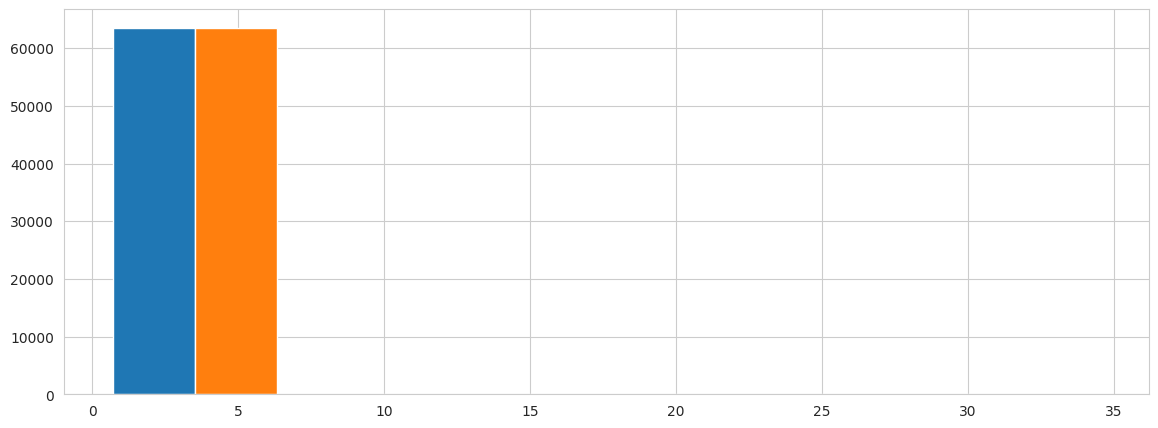

In [63]:
error = np.abs(y_test - y_pred)

plt.figure(figsize=(14, 5))
plt.hist(error, bins=5)